In [1]:
# from IPython.display import HTML

# HTML('''
# <script>
#   function code_toggle() {
#     if (code_shown){
#       $('div.input').hide('500');
#       $('#toggleButton').val('Show Code')
#     } else {
#       $('div.input').show('500');
#       $('#toggleButton').val('Hide Code')
#     }
#     code_shown = !code_shown
#   }

#   $( document ).ready(function(){
#     code_shown=false;
#     $('div.input').hide()
#   });
# </script>
# <form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
# ''')

par_log_transform = True

In [3]:
from pypacmensl.sensitivity.multi_sinks import SensFspSolverMultiSinks
import mpi4py.MPI as mpi
import numpy as np

import numpy.linalg as LA
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import binom, poisson, norm
from scipy.special import comb     
from math import exp, log, sqrt

from numba import jit

from chebpy import chebfun
import chebpy

from matplotlib.patches import Ellipse
from matplotlib.ticker import FormatStrFormatter
import ipywidgets as widgets

from scipy.stats import logistic
from IPython.display import clear_output

# For nice plots
import seaborn as sns
sns.set(style='darkgrid')

In [4]:
fsp_sol_file = np.load('fsp_solutions.npz', allow_pickle=True)
rna_distributions = fsp_sol_file['rna_distributions']
rna_sensitivities = fsp_sol_file['rna_sensitivities']
t_meas = fsp_sol_file['t_meas']
fsp_sol_file.close()

with np.load('bursting_parameters.npz') as par:
    k_on = par['kon']
    k_off = par['koff']
    k_r = par['kr']
    gamma = par['gamma']

theta = np.array([k_on, k_off, k_r, gamma])

## Exact smFISH measurement FIM

In [5]:
# FIM for exact smFISH measurements
fim_exact = np.zeros((len(t_meas), 4, 4))
for itime in range(0, len(t_meas)):
    M = np.zeros((4,4))
    for ip in range(0, 4):
        for jp in range(0, ip+1):
            M[ip, jp] = np.sum(rna_sensitivities[itime][ip]*rna_sensitivities[itime][jp]/
                               np.maximum(rna_distributions[itime], 1.0e-16))
    for ip in range(0,4):
        for jp in range(ip+1,4):
            M[ip, jp] = M[jp, ip]
    fim_exact[itime, : , :] = M
 
np.savez('fim_exact.npz', fim_exact=fim_exact)

## Modeling noise in flow cytometry measurement

## Modeling measurement noise with binomial distribution

The first noise we consider is that coming from inefficient probe binding, leading to the number of visible spots being lower than the actual mRNA copy number in the cell. 

Let $p_{bind}$ be the probability that a given mRNA molecule become visible, the number of spots recorded conditioned on the number of actual mRNA then follows a binomial distribution.

We will call this the "lossy" smFISH measurement.

In [8]:
p_success = 0.5
def BinomialNoiseMatrix(n_max, p_success):
    M = np.zeros((n_max + 1, n_max + 1))  
    for j in range(0, n_max + 1):
            M[:, j] = binom.pmf(np.linspace(0, n_max, n_max+1), j, p_success) 
    return M

n_max = 200
C_binom = BinomialNoiseMatrix(n_max, p_success)

fim_binom = np.zeros((len(t_meas), 4, 4))
for itime in range(0, len(t_meas)):
    M = np.zeros((4,4))
    xmax = len(rna_distributions[itime])-1
    p = C_binom[0:xmax+1, 0:xmax+1]@rna_distributions[itime]
    for ip in range(0, 4):
        sip = C_binom[0:xmax+1, 0:xmax+1]@rna_sensitivities[itime][ip]
        for jp in range(0, ip+1):
            sjp = C_binom[0:xmax+1, 0:xmax+1]@rna_sensitivities[itime][jp]
            M[ip, jp] = np.sum(sip*sjp/np.maximum(1.e-16, p))
    for ip in range(0,4):
        for jp in range(ip+1,4):
            M[ip, jp] = M[jp, ip]
    fim_binom[itime, :, :] = M
np.savez('fim_binom.npz', fim_binom=fim_binom)

## Modeling combinatorial noise from low image resolution

We consider spot miscounting due to low image resolution. Let $S$ be the size of the cell in terms of the pixels it occupies. Ignore for now the variability in cell sizes. Bright spots may clutter within a pixel, making the image looks like there is only one spot when there should actually be several of them.

Given cell size S and n mRNA molecules, the recorded number of spots is given by the formula
$$
P(Y = j | S, n)
=
\frac
{\binom{S}{j}\binom{n-1}{j-1}}
{\binom{S + n - 1}{n}}
$$

This comes from a combinatoric problem: Given $S$ boxes and $n$ apples, how many ways are there to distribute these apples into these boxes such that there are exactly $j$ non-empty boxes.

In [9]:
num_pixels = 100 # number of pixels occupied by a typical cells
def LowResNoiseMatrix(n_max):
    M = np.zeros((n_max + 1, n_max + 1))  
    M[0,0] = 1.0
    for j in range(1, n_max + 1):
            M[:, j] = comb(num_pixels, np.arange(0, n_max+1))*comb(j-1, np.arange(0,n_max+1)-1)/comb(num_pixels + j - 1, j)       
    return M

n_max = 200
C_lowres = LowResNoiseMatrix(n_max)

fim_lowres = np.zeros((len(t_meas), 4, 4))
for itime in range(0, len(t_meas)):
    M = np.zeros((4,4))
    xmax = len(rna_distributions[itime])-1
    p = C_lowres[0:xmax+1, 0:xmax+1]@rna_distributions[itime]
    for ip in range(0, 4):
        sip = C_lowres[0:xmax+1, 0:xmax+1]@rna_sensitivities[itime][ip]
        for jp in range(0, ip+1):
            sjp = C_lowres[0:xmax+1, 0:xmax+1]@rna_sensitivities[itime][jp]
            M[ip, jp] = np.sum(sip*sjp/np.maximum(1.e-16, p))
    for ip in range(0,4):
        for jp in range(ip+1,4):
            M[ip, jp] = M[jp, ip]
    fim_lowres[itime, :, :] = M
np.savez('fim_lowres.npz', fim_lowres=fim_lowres)

In [10]:
C_composite = C_binom@C_lowres

fim_composite = np.zeros((len(t_meas), 4, 4))
for itime in range(0, len(t_meas)):
    M = np.zeros((4,4))
    xmax = len(rna_distributions[itime])-1
    p = C_composite[0:xmax+1, 0:xmax+1]@rna_distributions[itime]
    for ip in range(0, 4):
        sip = C_composite[0:xmax+1, 0:xmax+1]@rna_sensitivities[itime][ip]
        for jp in range(0, ip+1):
            sjp = C_composite[0:xmax+1, 0:xmax+1]@rna_sensitivities[itime][jp]
            M[ip, jp] = np.sum(sip*sjp/np.maximum(1.e-16, p))
    for ip in range(0,4):
        for jp in range(ip+1,4):
            M[ip, jp] = M[jp, ip]
    fim_composite[itime, :, :] = M
np.savez('fim_composite.npz', fim_composite=fim_composite)

In [11]:
time_slider = widgets.IntSlider(value=0, min=0, max=len(t_meas)-1, step=1, description='Time:')

def plot_rna_dist_sens(itime):
    fig_smfish = plt.figure()
    fig_smfish.set_tight_layout(True)    
    xmax = len(rna_distributions[itime])-1
    p_binom = C_binom[0:xmax+1, 0:xmax+1]@rna_distributions[itime]
    p_composite = C_composite[0:xmax+1, 0:xmax+1]@rna_distributions[itime]
    p_lowres = C_lowres[0:xmax+1, 0:xmax+1]@rna_distributions[itime]
    
    fig_smfish.suptitle(f't = {t_meas[itime]:.2f}')
    ax0 = fig_smfish.add_subplot(1,1,1)
    ax0.plot(np.arange(0, xmax+1), rna_distributions[itime], label='True', linewidth=4)
    ax0.plot(np.arange(0, xmax+1), p_binom, color='orange', linestyle=':', label='Lossy')
    ax0.plot(np.arange(0, xmax+1), p_lowres, color='magenta', linestyle='dotted', label='Low-resolution')
    ax0.plot(np.arange(0, xmax+1), p_composite, color='red', linestyle=':', label='Composite noise')    
    ax0.set_xlabel('RNA molecule count')
    ax0.set_ylabel('Probability')    
    
    ax1 = ax0.twinx()
    xvals = np.logspace(-8, np.log10(xmax), 100)*kappa
    pflowcyt = flowcyt_intensity_prob[itime](xvals)
    ax1.plot(xvals/kappa, pflowcyt, color='green', linestyle='-', marker = 'v', label='Flow cytometry')
    ax1.tick_params(axis='y', labelcolor='green')
    ax1.set_ylabel('Probability density', color='green')
    
    fig_smfish.legend(bbox_to_anchor=(0.25, 0, 1, 1), loc = 'lower right')        


widgets.interactive(plot_rna_dist_sens, itime=time_slider)

interactive(children=(IntSlider(value=0, description='Time:', max=200), Output()), _dom_classes=('widget-inter…

In [12]:
with np.load('fim_exact.npz') as data:
    fim_exact = data['fim_exact']

with np.load('fim_binom.npz') as data:
    fim_binom = data['fim_binom']
    
with np.load('fim_lowres.npz') as data:
    fim_lowres = data['fim_lowres']  
    
with np.load('fim_composite.npz') as data:
    fim_composite = data['fim_composite']      
    
with np.load('fim_flowcyt.npz') as data:
    fim_flowcyt = data['fim_flowcyt']

if par_log_transform:
    for it in range(0, len(t_meas)):
        for i in range(0,4):
            for j in range(0,4):
                fim_exact[it, i, j] *= theta[i]*theta[j]*np.log(10)*np.log(10)
                fim_binom[it, i, j] *= theta[i]*theta[j]*np.log(10)*np.log(10)
                fim_lowres[it, i, j] *= theta[i]*theta[j]*np.log(10)*np.log(10)
                fim_flowcyt[it, i, j] *= theta[i]*theta[j]*np.log(10)*np.log(10)
                fim_composite[it, i, j] *= theta[i]*theta[j]*np.log(10)*np.log(10)

def plot_conf_ellipse(fim, num_sigma, ax, par_idx, color='red', label='my_ellipse'):
    covmat = np.linalg.inv(fim)
    [eigvals, eigvecs] = np.linalg.eig(covmat[np.ix_([par_idx[0],par_idx[1]], [par_idx[0],par_idx[1]])])
    mu0 = np.log10(theta[par_idx[0]])
    mu1 = np.log10(theta[par_idx[1]])
    sigma0 = np.sqrt(eigvals[0])
    sigma1 = np.sqrt(eigvals[1])

    ax.axvline(mu0, color='k', linestyle='-.')
    ax.axhline(mu1, color='k', linestyle='-.')
    
    rot_radian = np.arctan(eigvecs[1,0]/eigvecs[0,0])
    rot_degree = 360*rot_radian/(2*np.pi)
    
    ellipse = patches.Ellipse(xy=(mu0, mu1), width=2*num_sigma*sigma0, height=2*num_sigma*sigma1, angle=rot_degree,
                              fill=False, edgecolor=color, label=label)
    ax.add_patch(ellipse)

    return 0

def plot_uncertainties(itime, num_cells_smfish, num_cells_flowcyt):
    fim_mats = [fim_exact[itime, :, :], 
                fim_binom[itime, :, :], 
                fim_lowres[itime, :, :], 
                fim_composite[itime, :, :],
                fim_flowcyt[itime, :, :]]
    
    num_meas = [num_cells_smfish, num_cells_smfish, num_cells_smfish, num_cells_smfish, num_cells_flowcyt]
    
    design_labels = [f'smFISH \n Noise-free \n {num_cells_smfish} cells', 
                        f'smFISH \n Lossy spot \n {num_cells_smfish} cells',
                        f'smFISH \n Low resolution \n {num_cells_smfish} cells',
                        f'smFISH \n Combo \n {num_cells_smfish} cells',
                        f'flow cytometry \n Additive noise \n {num_cells_flowcyt} cells']
    
    design_colors = ['red', 'darkgreen', 'blue', 'magenta', 'orange']
    
    fig0 = plt.figure()
    fig0.set_tight_layout(True)
    ax0 = fig0.add_subplot(1,1,1)
    
    # The uncertainties in eigendirections of different experiments
    for i in range(0, len(fim_mats)):
        
        [eigval, eigvec] = np.linalg.eig(num_meas[i]*fim_mats[i])
        uncertainties = 1/np.sqrt(eigval)

        ax0.hlines(uncertainties, xmin = (2*i + 1)-0.75, xmax = (2*i + 1) + 0.75, color=design_colors[i], linewidth=2)
        
    ax0.set_yscale('log')
    ax0.set_xticks(2*np.arange(0, len(fim_mats)) + 1)    
    ax0.set_xticklabels(design_labels)
    ax0.set_ylabel('Uncertainty')
    fig0.suptitle(f't = {t_meas[itime]:.2f} \n')
    
    # The 3-sigma ellipses of different experiments
    fig1, axes1 = plt.subplots(1, 2)
    
    for i in range(0, len(fim_mats)):
        plot_conf_ellipse(num_meas[i]*fim_mats[i], 3, axes1[0], [0,1], design_colors[i], design_labels[i])
        plot_conf_ellipse(num_meas[i]*fim_mats[i], 3, axes1[1], [2,3], design_colors[i], design_labels[i]) 

    for i in range(0, 2):
        axes1[i].legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc='lower left')
        axes1[i].autoscale()

In [14]:
mu_bg
sigma_bg

200

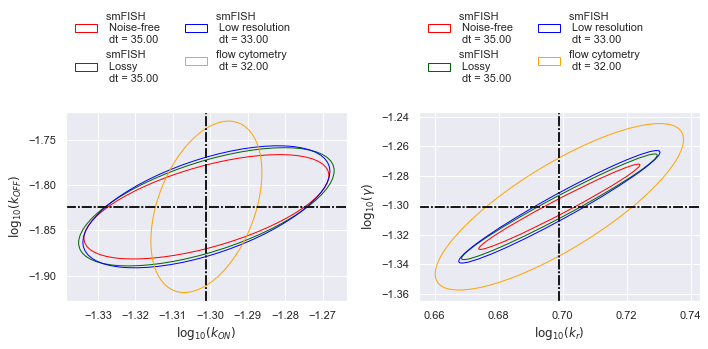

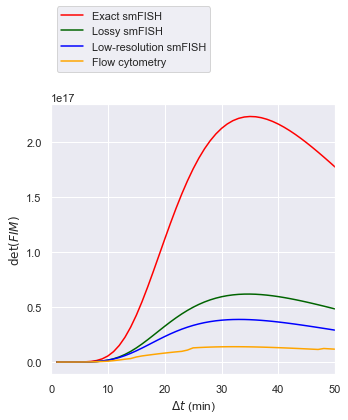

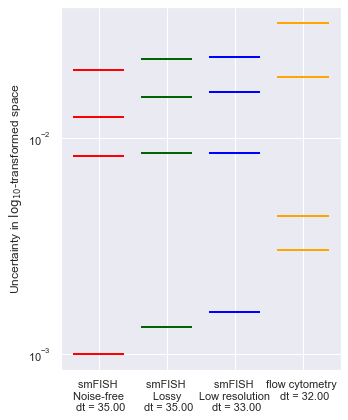

In [15]:
ncells_smfish = 1000
ncells_flowcyt = 10000

def compute_combined_fim(fim_array, dt, num_times, ncells):
    t_idx = dt*np.linspace(1, num_times, num_times, dtype=int)
    fim = ncells*fim_array[t_idx[0], :, :]
    for i in range(1, len(t_idx)):
        fim += ncells*fim_array[t_idx[i], :, :]
    return fim

num_times = 4
dt_min = 1
dt_max = int(np.floor(t_meas[-1]/num_times))
dt_array = np.linspace(dt_min, dt_max, dt_max - dt_min +1, dtype=int)

combined_fim_exact = np.zeros((len(dt_array), 4, 4))
combined_fim_binom = np.zeros((len(dt_array), 4, 4))
combined_fim_lowres = np.zeros((len(dt_array), 4, 4))
combined_fim_flowcyt = np.zeros((len(dt_array), 4, 4))

det_comb_fim_exact = np.zeros(len(dt_array))
det_comb_fim_binom = np.zeros(len(dt_array))
det_comb_fim_lowres = np.zeros(len(dt_array))
det_comb_fim_flowcyt = np.zeros(len(dt_array))


for i in range(0, len(dt_array)):
    combined_fim_exact[i, :, :] = compute_combined_fim(fim_exact, dt_array[i],  num_times, ncells_smfish)
    combined_fim_binom[i, :, :] = compute_combined_fim(fim_binom, dt_array[i], num_times, ncells_smfish)
    combined_fim_lowres[i, :, :] = compute_combined_fim(fim_lowres, dt_array[i],  num_times, ncells_smfish)    
    combined_fim_flowcyt[i, :, :] = compute_combined_fim(fim_flowcyt, dt_array[i],  num_times, ncells_flowcyt)
       
    det_comb_fim_exact[i] = np.linalg.det(combined_fim_exact[i,:,:])
    det_comb_fim_binom[i] = np.linalg.det(combined_fim_binom[i,:,:])
    det_comb_fim_lowres[i] = np.linalg.det(combined_fim_lowres[i,:,:])    
    det_comb_fim_flowcyt[i] = np.linalg.det(combined_fim_flowcyt[i,:,:])
    
num_meas = [ncells_smfish, ncells_smfish, ncells_smfish, ncells_smfish, ncells_flowcyt]

iopt_exact = np.argmax(det_comb_fim_exact)
iopt_binom = np.argmax(det_comb_fim_binom)
iopt_lowres = np.argmax(det_comb_fim_lowres)
iopt_flowcyt = np.argmax(det_comb_fim_flowcyt)

design_colors = ['red', 'darkgreen', 'blue', 'orange']

design_labels = [f'smFISH \n Noise-free \n dt = {dt_array[iopt_exact]:.2f}', 
                f'smFISH \n Lossy \n dt = {dt_array[iopt_binom]:.2f}',
                f'smFISH \n Low resolution \n dt = {dt_array[iopt_lowres]:.2f}',                
                f'flow cytometry \n dt = {dt_array[iopt_flowcyt]:.2f}']

fim_mats = [combined_fim_exact[iopt_exact, :, :], 
            combined_fim_binom[iopt_binom, :, :], 
            combined_fim_lowres[iopt_lowres, :, :],            
            combined_fim_flowcyt[iopt_flowcyt, :, :]]

fig, axes = plt.subplots(1,2)
fig.set_tight_layout(True)
fig.set_size_inches(10, 5)
# The 3-sigma ellipses of different experiments
for i in range(0, len(fim_mats)):
    plot_conf_ellipse(fim_mats[i], 3, axes[0], [0,1], design_colors[i], design_labels[i])
    plot_conf_ellipse(fim_mats[i], 3, axes[1], [2,3], design_colors[i], design_labels[i]) 

for i in range(0,2):
    axes[i].legend(bbox_to_anchor=(0, 1.1, 1, 1), loc='lower left', frameon=False, ncol=2)
    axes[i].autoscale()

axes[0].set_xlabel('$\log_{10}({k_{ON}})$')    
axes[0].set_ylabel('$\log_{10}({k_{OFF}})$')
axes[1].set_xlabel('$\log_{10}({k_{r}})$')    
axes[1].set_ylabel('$\log_{10}({\gamma})$')
fig.savefig('mle_ellipses.pdf')


        
fig, ax = plt.subplots(1,1)
fig.set_tight_layout(True)
fig.set_size_inches(5, 6)
ax.plot(dt_array, det_comb_fim_exact, label='Exact smFISH', color=design_colors[0])
ax.plot(dt_array, det_comb_fim_binom, label='Lossy smFISH', color=design_colors[1])        
ax.plot(dt_array, det_comb_fim_lowres, label='Low-resolution smFISH', color=design_colors[2])
ax.plot(dt_array, det_comb_fim_flowcyt, label='Flow cytometry', color=design_colors[3])
ax.legend(bbox_to_anchor=(0, 1.1, 1, 1), loc='lower left')
ax.set_xlim([0, 50])
ax.set_xlabel('$\Delta t$ (min)')
ax.set_ylabel('$\operatorname{det}(FIM)$')
fig.savefig('fim_dopt.pdf')

# The uncertainties in eigendirections of different experiments
fig, ax0 = plt.subplots(1,1)
fig.set_size_inches(5, 6)
for i in range(0, len(fim_mats)):
    [eigval, eigvec] = np.linalg.eig(fim_mats[i])
    uncertainties = 1/np.sqrt(eigval)

    ax0.hlines(uncertainties, xmin = (2*i + 1)-0.75, xmax = (2*i + 1) + 0.75, color=design_colors[i], linewidth=2)
fig.set_tight_layout(True)
ax0.set_yscale('log')
ax0.set_xticks(2*np.arange(0, len(fim_mats)) + 1)    
ax0.set_xticklabels(design_labels)
ax0.set_ylabel('Uncertainty in $\log_{10}$-transformed space')
fig.savefig('eig_uncertainties.pdf')

In [16]:
with np.load('ge_mle_misfits.npz') as file:
    fits_wrong = file['thetas']
with np.load('ge_mle_correct_fits.npz') as file:
    fits_right = file['thetas']
    
M = compute_combined_fim(fim_binom, 300, 100)

ipar0 = 2
ipar1 = 3
fig, ax = plt.subplots(1,1)
fig.set_tight_layout(True)
sns.scatterplot(fits_wrong[:,ipar0], fits_wrong[:,ipar1], ax = ax, label='MLE fits - no measurement error model')
sns.scatterplot(x=fits_right[:,ipar0], y=fits_right[:,ipar1], ax=ax, label='MLE fits - with measurement error model')
ax.set_xlabel('$\log_{10}({k_{r}})$')    
ax.set_ylabel('$\log_{10}({\gamma})$')
plot_conf_ellipse(M, 2, ax, [ipar0, ipar1], 'red', 'FIM-predicted two-sigma ellipse')
ax.autoscale()
ax.legend(bbox_to_anchor=(0, 1, 1, 1), loc='lower left')
fig.savefig('bursting_mle.pdf')

TypeError: compute_combined_fim() missing 1 required positional argument: 'ncells'

In [ ]:
time_slider = widgets.IntSlider(value=0, min=0, max=len(t_meas)-1, step=1, description='Time:')

def plot_rna_dist_sens(itime):
    fig_smfish = plt.figure()
    fig_smfish.set_tight_layout(True)
    gs = fig_smfish.add_gridspec(3, 2)
    xmax = len(rna_distributions[itime])-1
    p_binom = C_binom[0:xmax+1, 0:xmax+1]@rna_distributions[itime]
    p_composite = C_composite[0:xmax+1, 0:xmax+1]@rna_distributions[itime]
    p_lowres = C_lowres[0:xmax+1, 0:xmax+1]@rna_distributions[itime]
    
#     fig_smfish.suptitle(f't = {t_meas[itime]:.2f}')
    ax0 = fig_smfish.add_subplot(1,1,1)
    ax0.plot(np.arange(0, xmax+1), rna_distributions[itime], label='True', linewidth=4, color='red')
    ax0.plot(np.arange(0, xmax+1), p_binom, color='blue', linestyle=':', label='Distorted')
    ax0.set_xlabel('RNA molecule count')
    ax0.set_ylabel('Probability')        
    
    fig_smfish.legend()
    fig_smfish.savefig('true_v_distorted.pdf', bbox_inches='tight')


widgets.interactive(plot_rna_dist_sens, itime=time_slider)
